In [1]:
import sgf
import pandas as pd
from go_utils import *
from matplotlib import pyplot as plt
import matplotlib
from AlphaGo.go import GameState
import numpy as np
import tensorflow as tf
import pandas as pd
import random
from AlphaGo.preprocessing.game_converter import GameConverter
%load_ext autoreload
%autoreload 2
%matplotlib inline
from tflearn.data_flow import DataFlow,DataFlowStatus,FeedDictFlow
from tflearn.data_utils import Preloader,ImagePreloader
import scipy
from PIL import Image
import copy
from utils import Dataset,ProgressBar

Using TensorFlow backend.


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [2]:
GPU_CORE = 0
BATCH_SIZE = 128
BEGINING_LR = 0.01
TESTIMG_WIDTH = 500
model_name = '11_1_resnet'

In [4]:
copy.copy([1,2])

[1, 2]

In [105]:
class GoPreloader(object):
    def __init__(self,batch_size=64,datafile='data/sgf_list.csv'):
        self.batch_size=batch_size
        content = pd.read_csv(datafile,header=None,index_col=None)
        self.filelist = [i[0] for i in content.get_values()]
        self.pos = 0
        self.feature_list = [
            "board",
            "ones",
            "turns_since",
            "liberties",
            #"capture_size",
            #"self_atari_size",
            #"liberties_after",
            #"ladder_capture",
            #"ladder_escape",
            "sensibleness",
            "zeros"]
        self.gc = GameConverter(self.feature_list)
        self.batch_size = batch_size
        self.batch_iter = self.__iter()
        assert(len(self.filelist) > batch_size)
        self.game_iterlist = [None for i in self.filelist]
        
    def cod2array(self,cod,size=19):
        arr = np.zeros((size,size))
        arr[cod[0]][cod[1]] = 1
        return arr

    def __iter(self):
        retgo,retpred = [],[]
        filelist = []
        while True:
            for i in range(self.batch_size):
                if self.game_iterlist[i] == None:
                    if len(filelist) == 0:
                        filelist = copy.copy(self.filelist)
                        random.shuffle(filelist)
                    self.game_iterlist[i] = self.gc.convert_game(filelist.pop(),bd_size=19)
                game_iter = self.game_iterlist[i]
                
                try:
                    x,y = game_iter.__next__()
                    y = self.cod2array(y)
                    retgo.append(x)
                    retpred.append(y)
                    if len(retgo) >= self.batch_size:
                        yield (np.concatenate(retgo,axis=0),np.asarray(retpred))
                        retgo = []
                        retpred = []
                except StopIteration as e:
                    self.game_iterlist[i] = None

    def __getitem__(self, id):
        
        x,y = self.batch_iter.__next__()
        return x,y
        
    def __len__(self):
        return 10000

In [140]:
trainset = GoPreloader(datafile='data/train_list.csv',batch_size=BATCH_SIZE)
with tf.device("/gpu:{}".format(GPU_CORE)):
    coord = tf.train.Coordinator()
    trainflow = FeedDictFlow({
            'data':trainset,
        },coord,batch_size=BATCH_SIZE,shuffle=True,continuous=True,num_threads=1)
trainflow.start()

In [141]:
testset = GoPreloader(datafile='data/test_list.csv',batch_size=BATCH_SIZE)
with tf.device("/gpu:{}".format(GPU_CORE)):
    coord = tf.train.Coordinator()
    testflow = FeedDictFlow({
            'data':testset,
        },coord,batch_size=BATCH_SIZE,shuffle=True,continuous=True,num_threads=1)
testflow.start()

In [142]:
sample_x,sample_y = trainflow.next()['data']

In [163]:
sample_x,sample_y = testflow.next()['data']

In [164]:
#sample_x,sample_y = trainset[[1]]

In [168]:
sample_x.shape,sample_y.shape

((128, 22, 19, 19), (128, 19, 19))

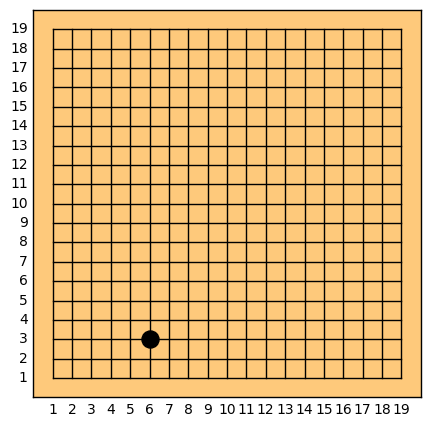

In [166]:
plot_board(sample_y[0],figsize=(5,5))


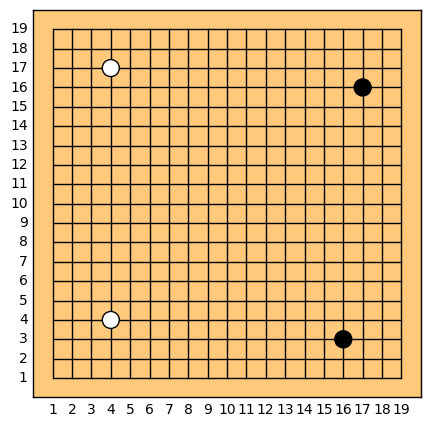

In [167]:
plot_board(sample_x[0][0] - sample_x[0][1],figsize=(5,5))

In [132]:
def res_block(inputx,name,training,block_num=2,filters=256,kernel_size=(3,3)):
    net = inputx
    for i in range(block_num):
        net = tf.layers.conv2d(net,filters=filters,kernel_size=kernel_size,activation=None,name="{}_res_conv{}".format(name,i),padding='same')
        net = tf.layers.batch_normalization(net,training=training,name="{}_res_bn{}".format(name,i))
        if i == block_num - 1:
            net = tf.concat((inputx,net),axis=-1)
        net = tf.nn.elu(net,name="{}_res_elu{}".format(name,i))
    return net

def conv_block(inputx,name,training,block_num=1,filters=2,kernel_size=(1,1),out_shape=(19,19)):
    net = inputx
    for i in range(block_num):
        net = tf.layers.conv2d(net,filters=filters,kernel_size=kernel_size,activation=None,name="{}_convblock_conv{}".format(name,i),padding='same')
        net = tf.layers.batch_normalization(net,training=training,name="{}_convblock_bn{}".format(name,i))
        net = tf.nn.elu(net,name="{}_convblock_elu{}".format(name,i))
    # net [None,19,19,2]
    netshape = net.get_shape().as_list()
    print(netshape)
    net = tf.reshape(net,shape=(-1,netshape[1] * netshape[2] * netshape[3]))
    net = tf.layers.dense(net,19 * 19,name="{}_dense".format(name))
    net = tf.nn.elu(net,name="{}_elu".format(name))
    return net

In [133]:
def gen_test_image_op(name):
    prediction_result = tf.placeholder(tf.float32, [None, TESTIMG_WIDTH,TESTIMG_WIDTH,3 ])
    prediction_result_op = tf.summary.image(name,prediction_result)
    return prediction_result,prediction_result_op

In [134]:
tf.reset_default_graph()
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
sess = tf.Session(config=config)

NUM_RES_LAYERS = 10

with tf.device("/gpu:{}".format(GPU_CORE)):
    X = tf.placeholder(tf.float32,[None,19,19,22])
    y = tf.placeholder(tf.float32,[None,19,19])
    training = tf.placeholder(tf.bool,name='training_mode')
    learning_rate = tf.placeholder(tf.float32)
    global_step = tf.train.get_or_create_global_step()
    
    net = X
    for i in range(NUM_RES_LAYERS):
        net = res_block(net,name="layer_{}".format(i + 1),training=training)
    
    net_unsoftmax = conv_block(net,name="conv",training=training)
    
    target = tf.reshape(y,(-1,19 * 19))
    with tf.variable_scope("Loss"):
        loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=target,logits=net_unsoftmax))
        loss_summary = tf.summary.scalar("softmax_loss",loss)
    net_softmax = tf.nn.softmax(net_unsoftmax)
    
    correct_prediction = tf.equal(tf.argmax(target,1), tf.argmax(net_softmax,1))
    
    
    with tf.variable_scope("Accuracy"):
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
        acc_summary = tf.summary.scalar("top_one",accuracy)
        
    summary_op = tf.summary.merge([loss_summary,acc_summary])
    
    
    train_data,train_op = gen_test_image_op("train_data")
    pred_data,pred_op = gen_test_image_op("pred")
    label_data,label_op = gen_test_image_op("label")
    pic_op = tf.summary.merge([train_op,pred_op,label_op])
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        optimizer = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
        train_op = optimizer.minimize(loss,global_step=global_step)

    train_summary_writer = tf.summary.FileWriter("./log/{}_train".format(model_name), sess.graph)
    test_summary_writer = tf.summary.FileWriter("./log/{}_test".format(model_name), sess.graph)

[None, 19, 19, 2]


In [135]:
sess.run(tf.global_variables_initializer())
tf.train.global_step(sess, global_step)

0

In [136]:
import os
if not os.path.exists("models/{}".format(model_name)):
    os.mkdir("models/{}".format(model_name))

In [137]:

def gen_plot(arr):
    """Create a pyplot plot and save to buffer."""
    buf = draw_board(arr)
    plot_image = Image.open(buf)
    pred_image = scipy.misc.imresize(scipy.asarray(plot_image),size=(TESTIMG_WIDTH,TESTIMG_WIDTH))
    pred_image = pred_image[:,:,:3]
    return pred_image

In [138]:
N_BATCH = 10000
N_BATCH_TEST = 300

In [ ]:
restore = False
N_EPOCH = 100
DECAY_EPOCH = 40

class ExpVal:
    def __init__(self,exp_a=0.97):
        self.val = None
        self.exp_a = exp_a
    def update(self,newval):
        if self.val == None:
            self.val = newval
        else:
            self.val = self.exp_a * self.val + (1 - self.exp_a) * newval
    def getval(self):
        return round(self.val,2)
    
expacc = ExpVal()
exploss = ExpVal()


begining_learning_rate = 1e-1

pred_image = None
if restore == False:
    train_epoch = 1
    train_batch = 0
for one_epoch in range(train_epoch,N_EPOCH):
    train_epoch = one_epoch
    pb = ProgressBar(worksum=N_BATCH * BATCH_SIZE,info=" epoch {} batch {}".format(train_epoch,train_batch))
    pb.startjob()
    
    for one_batch in range(N_BATCH):
        if restore == True and one_batch < train_batch:
            pb.auto_display = False
            pb.complete(BATCH_SIZE)
            pb.auto_display = True
            continue
        else:
            restore = False
        train_batch = one_batch
        
        batch_x,batch_y = trainflow.next()['data']
        batch_x = np.transpose(batch_x,[0,2,3,1])
        #batch_y = np.transpose(batch_y,[0,2,1])
        
        
        # learning rate decay strategy
        batch_lr = begining_learning_rate * 10 ** -(one_epoch // DECAY_EPOCH)
        
        batch_result,_,step_loss,step_acc,step_summary,step_value,step_summary = sess.run(
            [net_unsoftmax,train_op,loss,accuracy,summary_op,global_step,summary_op],feed_dict={
                X:batch_x,y:batch_y,learning_rate:batch_lr,training:True
            })
        train_summary_writer.add_summary(step_summary,step_value)
        step_acc *= 100
        expacc.update(step_acc)
        exploss.update(step_loss)

        if  one_batch % 100 == 0:
            plot_x,plot_target,plot_pred = [],[],[]
            for i in range(4):
                plot_x.append(gen_plot(batch_x[i,:,:,0] - batch_x[i,:,:,1]))
                plot_target.append(gen_plot(batch_y[i]))
                index = np.argmax(batch_result[i].reshape(-1))
                pp = np.zeros(19 * 19)
                pp[index] = 1
                pp = pp.reshape(19,19)
                plot_pred.append(gen_plot(pp))
            plot_x,plot_target,plot_pred = np.asarray(plot_x),np.asarray(plot_target),np.asarray(plot_pred)
            step_img = sess.run(pic_op,feed_dict={train_data:plot_x,pred_data:plot_pred,label_data:plot_target})
            train_summary_writer.add_summary(step_img,step_value)
        
        pb.info = "EPOCH {} STEP {} LR {} ACC {} LOSS {} ".format(
            one_epoch,one_batch,batch_lr,expacc.getval(),exploss.getval())
        
        pb.complete(BATCH_SIZE)
    print()
    accs = []
    losses = []
    pb = ProgressBar(worksum=N_BATCH_TEST * BATCH_SIZE,info="validating epoch {} batch {}".format(train_epoch,train_batch))
    pb.startjob()
    for one_batch in range(N_BATCH_TEST):
        batch_x,batch_y = testflow.next()['data']
        batch_x = np.transpose(batch_x,[0,2,1,3])
        batch_y = np.transpose(batch_y,[0,2,1])
        batch_result,step_loss,step_acc,step_summary,step_value,step_summary = sess.run(
            [net_unsoftmax,loss,accuracy,summary_op,global_step,summary_op],feed_dict={
                X:batch_x,y:batch_y,training:False
            })
        test_summary_writer.add_summary(step_summary,step_value)
        accs.append(step_acc)
        losses.append(step_loss)
        if one_batch % 100 == 0:
            plot_x,plot_target,plot_pred = [],[],[]
            for i in range(4):
                plot_x.append(gen_plot(batch_x[i,:,:,0] - batch_x[i,:,:,1]))
                plot_target.append(gen_plot(batch_y[i]))
                index = np.argmax(batch_result[i].reshape(-1))
                pp = np.zeros(19 * 19)
                pp[index] = 1
                pp = pp.reshape(19,19)
                plot_pred.append(gen_plot(pp))
            plot_x,plot_target,plot_pred = np.asarray(plot_x),np.asarray(plot_target),np.asarray(plot_pred)
            step_img = sess.run(pic_op,feed_dict={train_data:plot_x,pred_data:plot_pred,label_data:plot_target})
            test_summary_writer.add_summary(step_img,step_value + one_batch)
        
        pb.complete(BATCH_SIZE)
    print("TEST ACC {} LOSS {}".format(np.average(accs),np.average(losses)))
    print()
    saver = tf.train.Saver()
    saver.save(sess,"models/{}/model_{}".format(model_name,one_epoch))

EPOCH 1 STEP 227 LR 0.1 ACC 3.05 LOSS 4.97  2.28 % [=>-------------------------------------------------] 29184/1280000 	 used:314s eta:13481 s